In [8]:
import sys
sys.path.append('../')

import torch
import numpy as np
import PIL
import PIL.Image
import matplotlib.pyplot as plt
from tools.img import rgb2yuv, yuv2rgb, get_shifted_amp_pha, clip
import scipy.fftpack
from tools.utils import manual_seed

manual_seed(42)

The effect of Phase Trigger in U channel

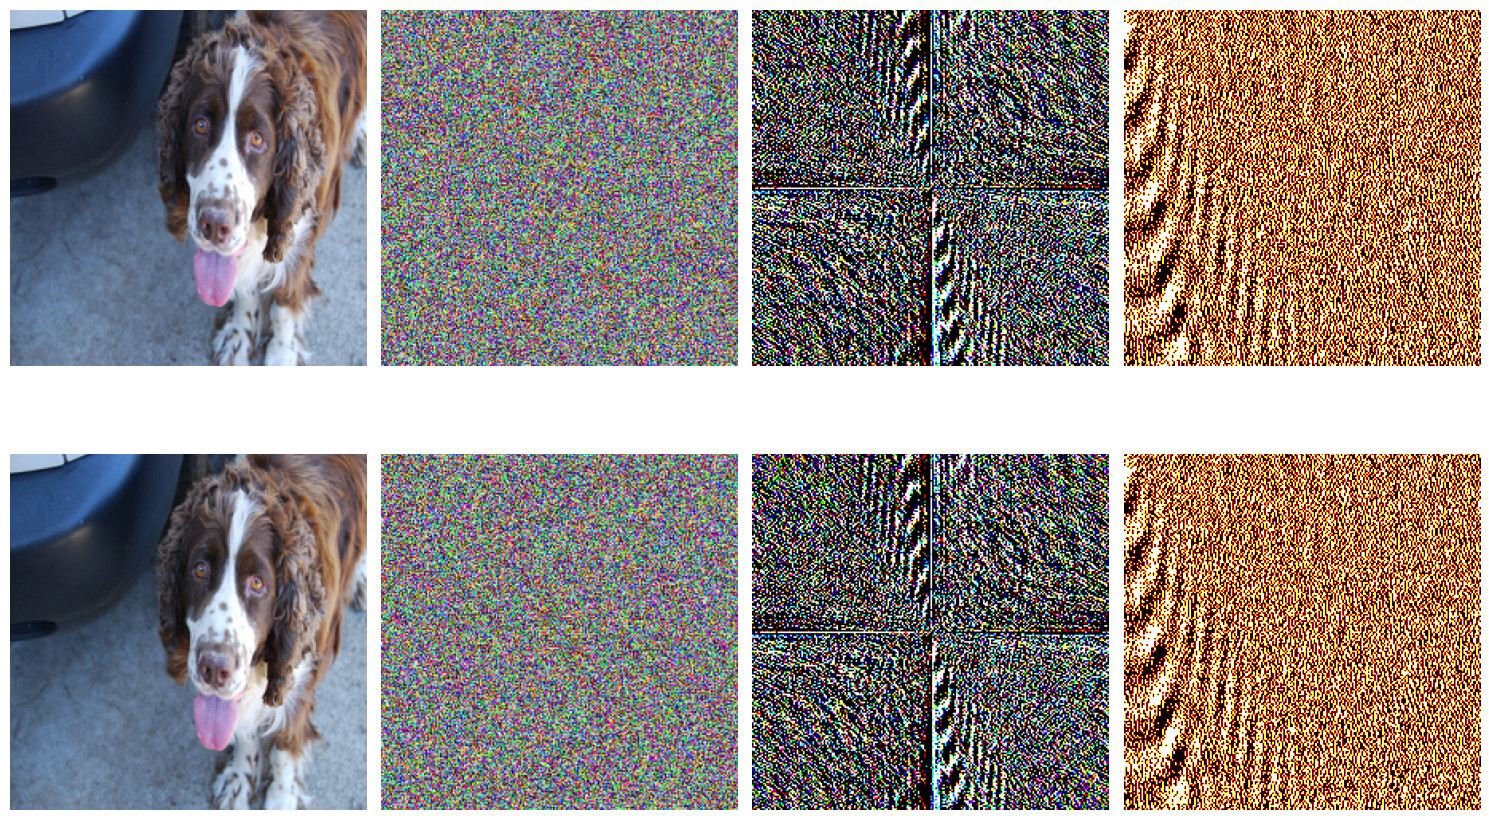

In [9]:
x_img = PIL.Image.open('../resource/example/imagenette_dog.JPEG')
scale = 224
tg_size = 15  # tg_size
tg_pos = int(scale / 2)
x_img = x_img.resize((scale, scale))
x_c = np.array(x_img)

_, ax = plt.subplots(2, 4, figsize=(15, 10))
for axes in ax.flat:
    axes.set_axis_off()

ax[0, 0].imshow(x_c)

x_c_amp_sh, x_c_pha_sh = get_shifted_amp_pha(x_c)
ax[0, 1].imshow(x_c_amp_sh.astype(np.uint8))
ax[0, 2].imshow(x_c_pha_sh.astype(np.uint8))
x_c_dct = scipy.fftpack.dctn(x_c, axes=(-3, -2))
ax[0, 3].imshow(clip(x_c_dct[:, :, 0]), cmap='hot')

x_c_yuv = rgb2yuv(x_c)
x_c_yuv_fft = np.fft.fft2(x_c_yuv, axes=(-3, -2))
x_c_yuv_fft_amp, x_c_yuv_fft_pha = np.abs(x_c_yuv_fft), np.angle(x_c_yuv_fft)
x_c_yuv_fft_pha[tg_pos-tg_size:tg_pos+tg_size, tg_pos-tg_size:tg_pos+tg_size, 1] = np.pi
x_p_yuv_fft = x_c_yuv_fft_amp * np.exp(1j * x_c_yuv_fft_pha)
x_p_yuv = np.fft.ifft2(x_p_yuv_fft, axes=(-3, -2)).real
x_p = yuv2rgb(x_p_yuv)
x_p = np.clip(x_p, 0, 255).astype(np.uint8)

x_p_amp_sh, x_p_pha_sh = get_shifted_amp_pha(x_p)

ax[1, 0].imshow(x_p)
ax[1, 1].imshow(x_p_amp_sh.astype(np.uint8))
ax[1, 2].imshow(x_p_pha_sh.astype(np.uint8))
ax[1, 2].imshow(x_p_pha_sh.astype(np.uint8))

x_p_dct = scipy.fftpack.dctn(x_p, axes=(-3, -2))
ax[1, 3].imshow(clip(x_p_dct[:, :, 0]), cmap='hot')


plt.tight_layout()
plt.show()

The effect of Mask to Y channel

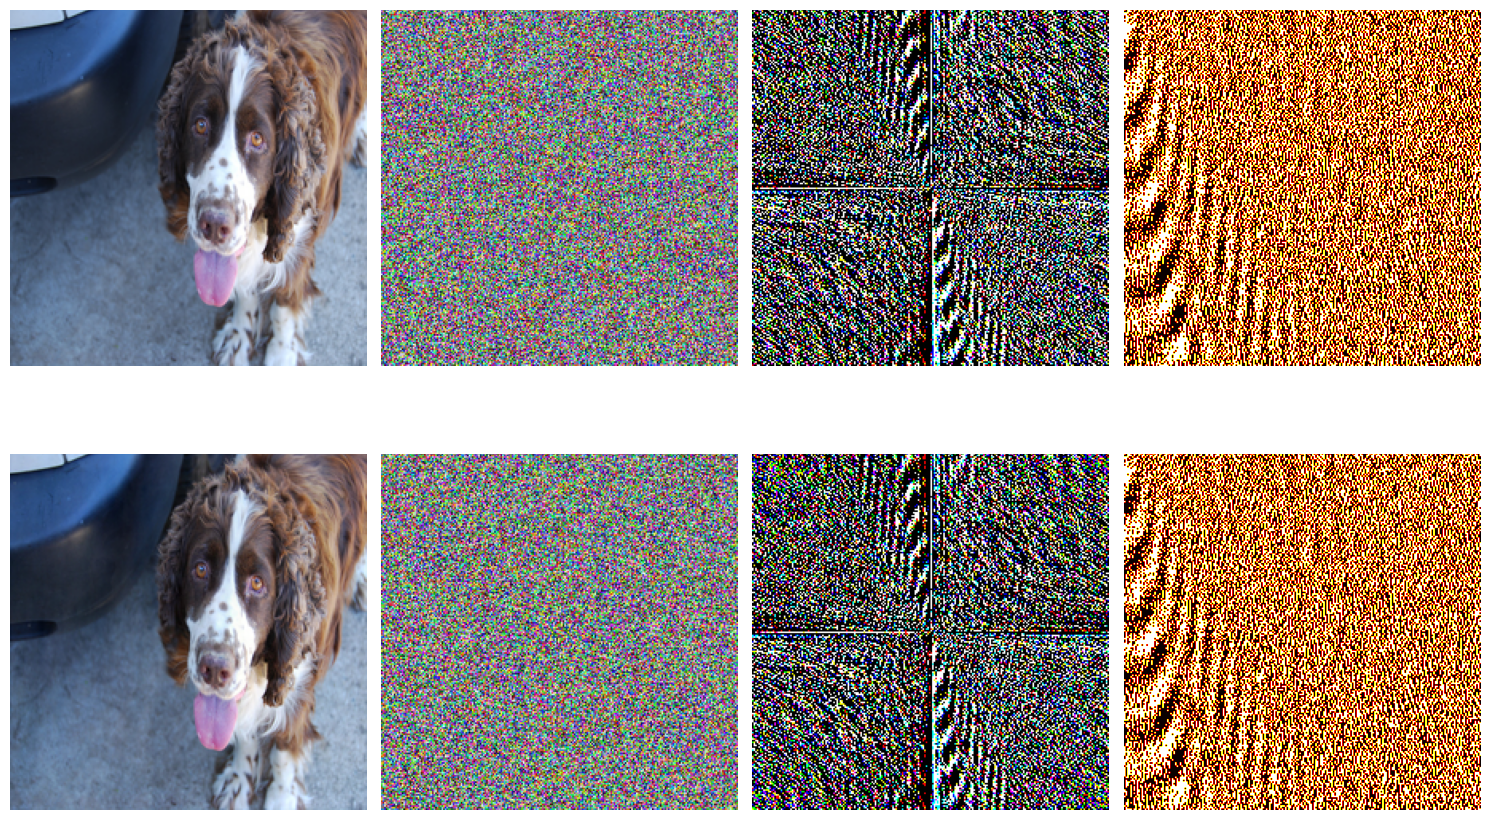

In [10]:
_, ax = plt.subplots(2, 4, figsize=(15, 10))
for axes in ax.flat:
    axes.set_axis_off()
ax[0, 0].imshow(x_c)

ax[0, 1].imshow(x_c_amp_sh.astype(np.uint8))
ax[0, 2].imshow(x_c_pha_sh.astype(np.uint8))
x_c_dct = scipy.fftpack.dctn(x_c, axes=(-3, -2))
ax[0, 3].imshow(clip(x_c_dct[:,:,0]), cmap='hot')


x_fft_real = x_p_yuv_fft.real
x_fft_imag = x_p_yuv_fft.imag

mask = np.random.choice([1, 0.7], size=(scale, scale))  # threshold
mask[:3, :3] = 1

x_fft_imag[:, :, 0] *= mask

x_p_yuv_fft = x_fft_real + 1j * x_fft_imag
x_p_yuv_fft_amp, x_p_yuv_fft_pha = np.abs(x_p_yuv_fft), np.angle(x_p_yuv_fft)
x_p_yuv_fft[:, :, 1] = x_c_yuv_fft_amp[:, :, 1] * np.exp(1j * x_p_yuv_fft_pha[:, :, 1])


x_p_yuv = np.fft.ifft2(x_p_yuv_fft, axes=(-3, -2))
x_p = yuv2rgb(x_p_yuv)

x_p_fft = np.fft.fft2(x_p, axes=(-3, -2))
amp_p, pha_p = np.abs(x_p_fft), np.angle(x_p_fft)
x_c_fft = np.fft.fft2(x_c, axes=(-3, -2))
amp_c, pha_c = np.abs(x_c_fft), np.angle(x_c_fft)

# change amp
x_p_fft_mix = amp_c * np.exp(1j * pha_p)
x_p = np.fft.ifft2(x_p_fft_mix, axes=(-3, -2)).real


x_p = np.clip(x_p, 0, 255).astype(np.uint8)
x_p_amp_sh, x_p_pha_sh = get_shifted_amp_pha(x_p)


ax[1, 0].imshow(x_p)
ax[1, 1].imshow(x_p_amp_sh.astype(np.uint8))
ax[1, 2].imshow(x_p_pha_sh.astype(np.uint8))

x_p_dct = scipy.fftpack.dctn(x_p, axes=(-3, -2))
ax[1, 3].imshow(clip(x_p_dct[:,:,0]), cmap='hot')

plt.tight_layout()
plt.show()

In [11]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

print(ssim(x_p, x_c, data_range=1, win_size=3), psnr(x_c, x_p))
(x_c.astype(float) - x_p.astype(float)).mean()

0.9913160202852186 38.225653771055754


0.5006975446428571

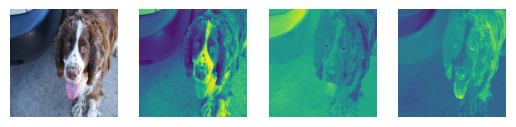

In [12]:
x = x_c
x_yuv = rgb2yuv(x)

_, ax = plt.subplots(1, 4)
for axes in ax.flat:
    axes.set_axis_off()
ax[0].imshow(x)
ax[1].imshow(x_yuv[:, :, 0])
ax[2].imshow(x_yuv[:, :, 1])
ax[3].imshow(x_yuv[:, :, 2])

plt.show()

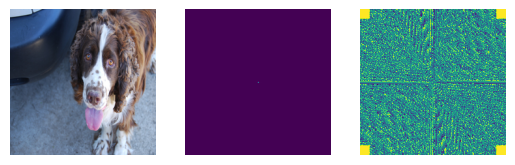

In [13]:
x_u = x_yuv[:, :,1]

x_u_fft = np.fft.fft2(x_u)
amp, pha = np.abs(x_u_fft), np.angle(x_u_fft)
pha[tg_pos-tg_size:tg_pos+tg_size, tg_pos-tg_size:tg_pos+tg_size] = np.pi

pha = np.fft.fftshift(pha)
amp = np.fft.fftshift(amp)


_, ax = plt.subplots(1, 3)
for axes in ax.flat:
    axes.set_axis_off()
ax[0].imshow(x)
ax[1].imshow(amp)
ax[2].imshow(pha)

plt.show()

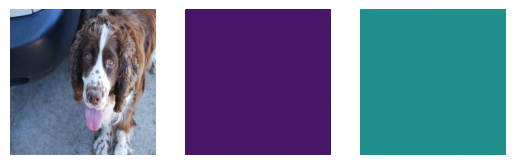

In [14]:
x_y = x[:, :, 0]
x_y_fft = np.fft.fft2(x_y)
re, im = x_y_fft.real, x_y_fft.imag

mask = np.random.choice([1, 0], size=(scale, scale))  # threshold
mask[:3, :3] = 1


im *= mask

_, ax = plt.subplots(1, 3)
for axes in ax.flat:
    axes.set_axis_off()
ax[0].imshow(x)
ax[1].imshow(re)
ax[2].imshow(im)

plt.show()